### Problem 2.2 (Exploring fish sleep data, 65 pts) 

In [Tutorial 2](../tutorials/t2a_tidy_data.html), we used a data set dealing with zerbafish sleep to learn about tidy data and split-apply-combine. It was fun to work with the data and to make some plots of fish activity over time. In this problem, you will work with your group to come up with some good ways to parametrize sleep behavior and estimate the values of these parameters.

Choose two different ways to parametrize sleep behavior.  You can use sleep metrics from the [Prober, et al. paper](https://doi.org/10.1523/JNEUROSCI.4332-06.2006) or (for more fun) invent your own.  For each of the ways of parametrizing sleep, provide instructive plots and estimate the values of the parameters. Be sure to discuss the rationale behind choosing your parametrizations.

Note that there is a lot of debate among the community of scientists studying sleep how to best quantify the behavior. This is generally true in studies of behavior, and much of the process of understanding the measurements is deciding on what to use as metrics. This problem obviously has no right answer. What is important is that you can provide a clear rational for your choices.

As you work through this problem, much of what you will do is exploratory data analysis. You will work with data frames to compute the behavioral metrics of interest and make instructive plots. Again, this problem is intentionally open-ended. You are taking a data set and making plots that you might put in a presentation or in a paper to describe the behavior. As you do the analysis, provide text that discusses your choice and what conclusions you can draw from your analyses.

You do not need to do any data validation (we'll get to that next week). You can download and use the resampled data set you generated in Tutorial 2 [here](../data/130315_1A_aanat2_resampled.csv). If you feel that you need to use the original data set, you can get the activity file [here](../data/130315_1A_aanat2.csv) and the genotypes file [here](../data/130315_1A_genotypes.txt).

## Solution

In [37]:
import itertools

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.integrate

# Import Altair for high level plotting
import altair as alt
import altair_catplot as altcat

# Import Bokeh modules for interactive plotting
import bokeh.io
import bokeh.plotting

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

# Pevent bulky altair plots
alt.data_transformers.enable('json')

Loading BokehJS ...

DataTransformerRegistry.enable('json')

We will begin by loading in the position data using pandas, and combining the file containing fish species with the position and activity data to synthesize a single dataframe. 

In [38]:
df = pd.read_csv('../data/130315_1A_aanat2.csv', comment='#')

# Load in the genotype file, call it df_gt for genotype DataFrame
df_gt = pd.read_csv('../data/130315_1A_genotypes.txt',
                    delimiter='\t',
                    comment='#',
                    header=[0, 1])

# Reset the columns to be the second level of indexing
df_gt.columns = df_gt.columns.get_level_values(1)

# Rename Columns to be more informative
df_gt.columns = ['wt', 'het', 'mut']

# Assign column names as attributes rather than columns themseves.
df_gt = pd.melt(df_gt, var_name='genotype', value_name='location')

# Take a look at the genotype dataframe
df_gt.head(5)

,genotype,location
0,wt,2.0
1,wt,14.0
2,wt,18.0
3,wt,24.0
4,wt,28.0


The overarching goal of our analysis is to determine the differences in sleeping patterns between different fish genotypes. Fish who were not assigned a genotype will thus not be considered, as they will not aid in our comparison. 

In [39]:
# Drop all rows that have a NaN in them. This will eliminate 
# all fish for which the genotype was not determined. 
df_gt = df_gt.dropna()
df_gt = df_gt.reset_index(drop=True)

# Location value is a float, but we would prefer an integer. 
df_gt.loc[:,'location'] = df_gt.loc[:, 'location'].astype(int)

# Combine genotype and activity data using location as a common column.
df = pd.merge(df, df_gt)

# Cast the time field as a datetime object. This will make manipulating
# time values much more convenient. 
df['time'] = pd.to_datetime(df['time'])

# Add a light/dark column that denotes the time of day for each activity level.
df['light'] = (  (df['time'].dt.time >= pd.to_datetime('9:00:00').time())
               & (df['time'].dt.time < pd.to_datetime('23:00:00').time()))

In [40]:
# Let's take a look at the processed data so far. 
df.head(3)

,location,activity,time,zeit,zeit_ind,day,genotype,light
0,1,0.6,2013-03-15 18:31:09,-14.480833,-869,4,het,True
1,1,1.9,2013-03-15 18:32:09,-14.464167,-868,4,het,True
2,1,1.9,2013-03-15 18:33:09,-14.447500,-867,4,het,True


The experiment did not actually start until zeit = 0, so we would like to eliminate this data from the dataframe. 

In [41]:
df = df[df['zeit'] >= 0]
df.head(3)

,location,activity,time,zeit,zeit_ind,day,genotype,light
869,1,0.0,2013-03-16 09:00:09,0.002500,0,5,het,True
870,1,0.0,2013-03-16 09:01:09,0.019167,1,5,het,True
871,1,0.0,2013-03-16 09:02:09,0.035833,2,5,het,True


We now want to split these dataframes by fish ID, so that we can plot each fish's activity separately. 

In [42]:
# Separate parent DF into separate dataframes for each fish
frames = []
for i in range(1, 97):
    # Isolate a single fish
    temp_df = df[df['location'] == i]
    
    # ensure there is data for this fish prior to adding it to frames
    if temp_df.shape[0] != 0:
        frames.append(temp_df)
print("We will analyze %i fish!" %len(frames))
frames[2].head()

We will analyze 73 fish!


,location,activity,time,zeit,zeit_ind,day,genotype,light
11595,3,0.8,2013-03-16 09:00:09,0.002500,0,5,het,True
11596,3,0.4,2013-03-16 09:01:09,0.019167,1,5,het,True
11597,3,0.0,2013-03-16 09:02:09,0.035833,2,5,het,True
11598,3,0.0,2013-03-16 09:03:09,0.052500,3,5,het,True
11599,3,1.3,2013-03-16 09:04:09,0.069167,4,5,het,True


The simplest way we could think to characterize sleep using this activity data is the duration of inactivity. Thus, we would like to identify each period of inactivity and characterize its length. In the following code, we define a period of inactivity as a timespan during which the activity score for each minute was less than 1. We then mark the start of each period of inactivity with the length of that inactivity period, and set all other values to 0. These values will then be appended to our data in a column labeled "Inactivity Begun."

In [43]:
# This will be a master array that will contain inactivity begun for all fish. 
# It will line up exactly with the dataframe df.
total_inactivity_begun = np.empty([0])

num_nonlinear_datapoints = 0

# Loop through Dataframes
for i, d in enumerate(frames):
    inactivity_begun = np.empty([0])
    inactive_minutes_count = 0
    for index, row in d.iterrows():
        
        # There are some datapoints between which more than one minute passed. 
        # We will ignore these, and count them as zero. 
        # This first condition is so that this code doesn't apply if we just 
        # changed dataframes. 
        if (index - d.index.values[0] != 0):
            time_prev = d["zeit_ind"][index - 1]
            time_now  = d["zeit_ind"][index]
            if (time_now - time_prev != 1):
                inactivity_begun = np.append(inactivity_begun, 
                                             [0] * (inactive_minutes_count + 1))
                num_nonlinear_datapoints += inactive_minutes_count + 1
                inactive_minutes_count = 0
                # move onto the next row without executing anything else
                continue
        
        # If the fish is inactive, we just count and wait.
        if row['activity'] < 1:
            inactive_minutes_count += 1
            
            # If the fish is inactive when the dataframe is ending, we need to update regardless.
            # Accessing the index is complex because we are working with indicies from the original 
            # data. 
            if (index - d.index.values[0] == d.shape[0] - 1):
                inactivity_begun = np.append(inactivity_begun, [inactive_minutes_count])
                inactivity_begun = np.append(inactivity_begun, [0] * (inactive_minutes_count - 1))
            
        else: 
            if inactive_minutes_count == 0:
                # If the fish is active, we can update this immediately
                inactivity_begun = np.append(inactivity_begun, [0])

            else: 
                # If we are coming from a period of inactivity, we need to 
                # update the array to include the initial count and the following 
                # zeros.
                inactivity_begun = np.append(inactivity_begun, [inactive_minutes_count])
                inactivity_begun = np.append(inactivity_begun, [0] * inactive_minutes_count)
                inactive_minutes_count = 0
    
    # Update the total array so that the parent dataframe may be edited
    total_inactivity_begun = np.append(total_inactivity_begun, inactivity_begun)
    
# Double Check to ensure that we collected the right amount of data
print("Length of total inactivity begun array: %i" % len(total_inactivity_begun))
print("Length of dataframe for all fish:       %i" % df.shape[0])
print("%i datapoints were removed due to nonlinear time." % num_nonlinear_datapoints)
df["InactivityBegun" ] = total_inactivity_begun
df.head(5)

Length of total inactivity begun array: 328062
Length of dataframe for all fish:       328062
234 datapoints were removed due to nonlinear time.


,location,activity,time,zeit,zeit_ind,day,genotype,light,InactivityBegun
869,1,0.0,2013-03-16 09:00:09,0.002500,0,5,het,True,4.0
870,1,0.0,2013-03-16 09:01:09,0.019167,1,5,het,True,0.0
871,1,0.0,2013-03-16 09:02:09,0.035833,2,5,het,True,0.0
872,1,0.0,2013-03-16 09:03:09,0.052500,3,5,het,True,0.0
873,1,4.2,2013-03-16 09:04:09,0.069167,4,5,het,True,0.0


This looks exactly as intended! Now we can start to explore this data, and choose a time threshold past which we will consider the zebrafish to be sleeping. 

In [44]:
df_inactive = df[df["InactivityBegun"] > 1] # First we will consider the lowest reasonable threshold

Let's plot all this inactivity begun data fish-by-fish. 

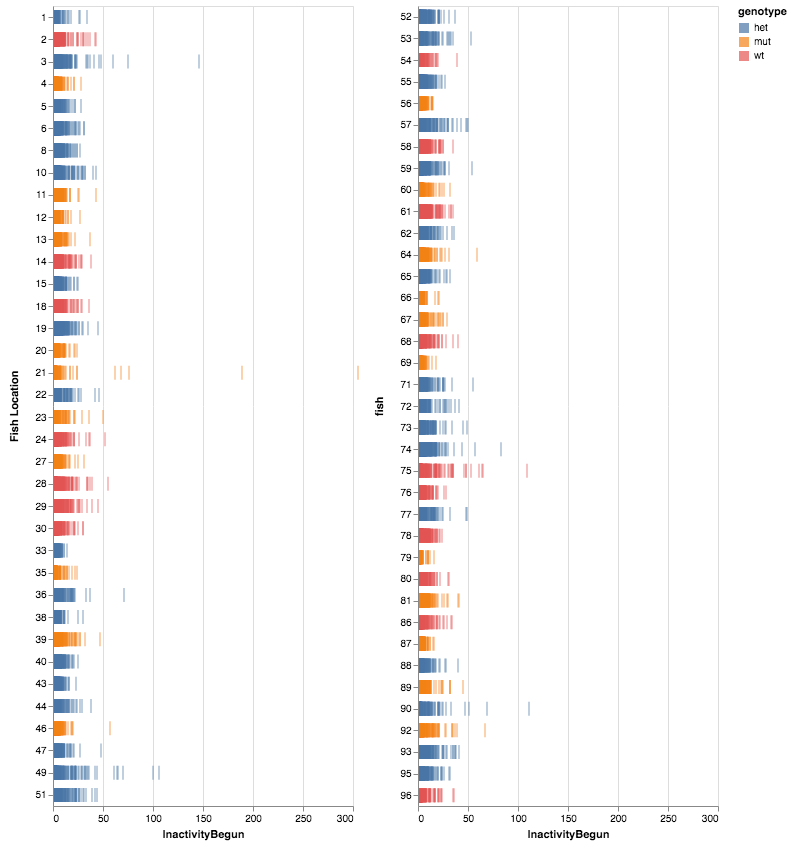

In [45]:
p1 = alt.Chart(df_inactive[df_inactive['location'] < 52], 
               width = 300, 
               height = 800
    ).mark_tick(
    ).encode(
        x=alt.X('InactivityBegun:Q', scale=alt.Scale(domain = [0, 300])),
        y=alt.Y('location:N', title='Fish Location'),
        color=alt.Color('genotype:N', title="genotype")
    )
p2 = alt.Chart(df_inactive[df_inactive['location'] >= 52], 
               width = 300,
               height = 800
    ).mark_tick(
    ).encode(
        x=alt.X('InactivityBegun:Q', scale=alt.Scale(domain = [0, 300])),
        y=alt.Y('location:N', title='fish'),
        color=alt.Color('genotype:N', title="genotype")
    )
p1 | p2

This plot has a number of problems. For *naps* less than ten minutes in length, the plot is completely saturated across all fish. It seems like most of the variability between the fish is within the number of longer naps. Additionally, when exploring these plots, we found that there were some outlier sleeping zebrafish. One zebrafish (at location 21) slept continuously for over 300 minutes! The remainder of the data seems to suggest that zebrafish do not normally sleep for that long, and these points threw off the scale of the graph, and prevented us from visualizing all the data within a reasonable range. Let's examine these points using the resampled data from the tutorial:

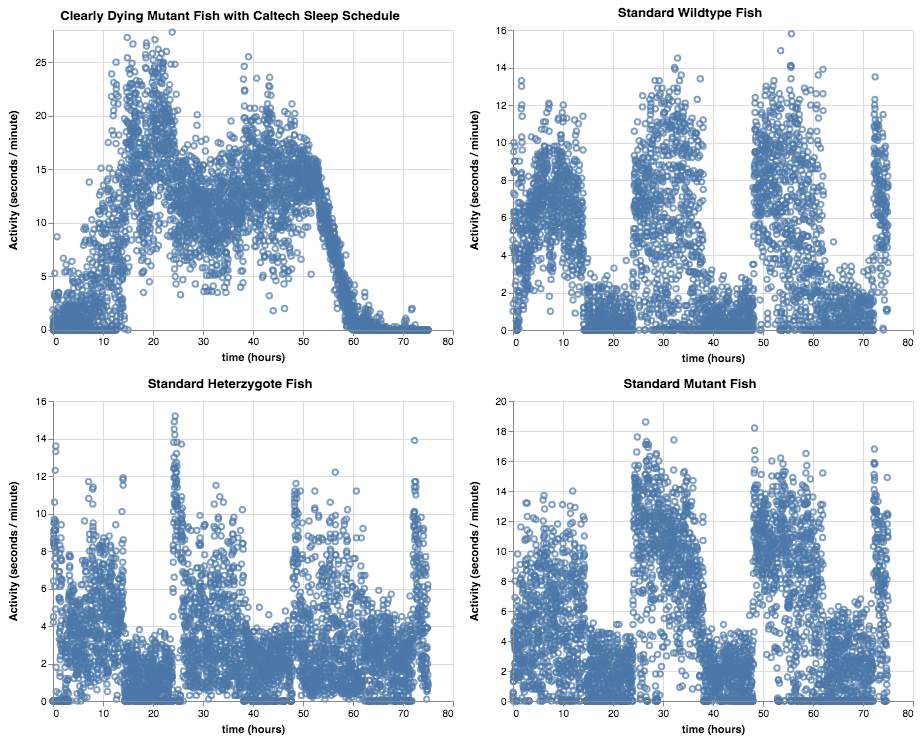

In [46]:
# I want to see what happened to the fish at location 21. Perhaps
# this fish is just an exceptional napper. 
def plot_single_fish(dataframe, location, title):
    c= alt.Chart(dataframe[df['location']==location]
        ).mark_point(
        ).encode(
            x=alt.X('zeit:Q', title='time (hours)'),
            y=alt.Y('activity:Q', title = "Activity (seconds / minute)"),
            order='zeit:Q',
        ).properties(title=title)
    return c

# I arbitrarily chose to plot fish from the first couple of wells for comparison
((plot_single_fish(df, 21, "Clearly Dying Mutant Fish with Caltech Sleep Schedule") |
  plot_single_fish(df, 2, "Standard Wildtype Fish")) &
 (plot_single_fish(df, 1, "Standard Heterzygote Fish") |
  plot_single_fish(df, 4, "Standard Mutant Fish")))

From the activity plots above, we can infer that fish 21 died mid-experiment, given that its activity patterns are erratic even in comparison to fish of similar genotype, and also given that the fish reached the end of the experiment after in-excess of 15 hours of continuous inactivity. It's possible that the mutation led to this erratic behavior, but it is not a representative fish and may be filtered out. 

We do need to set a threshold past which we will consider a zebrafish to be sleeping. This is arbitrary choice, as for any reasonable guess, there will be error for any threshold we choose, and no reasonable way to identify whether a zebrafish was sleeping or just lying still. We chose 5 minutes. 

In [59]:
# Define a constant 5-minute threshold
THRESH = 5

# Filter out fish 21
df = df[df['location'] != 21]

# Reset df_inactive to reflect filtering
df_inactive = df[df["InactivityBegun"] > THRESH] 

# Find the maximum sleep length left in the dataset:
m = np.max(df_inactive['InactivityBegun'].values)
print("The longest sleeping fish slept for %i minutes. " %m)

The longest sleeping fish slept for 146 minutes. 


A range from 5-146 minutes will permit us to make a much more reasonable-looking plot, even if this maximum is an outlier. Let's now examine the distribution for all the fish more spread out.

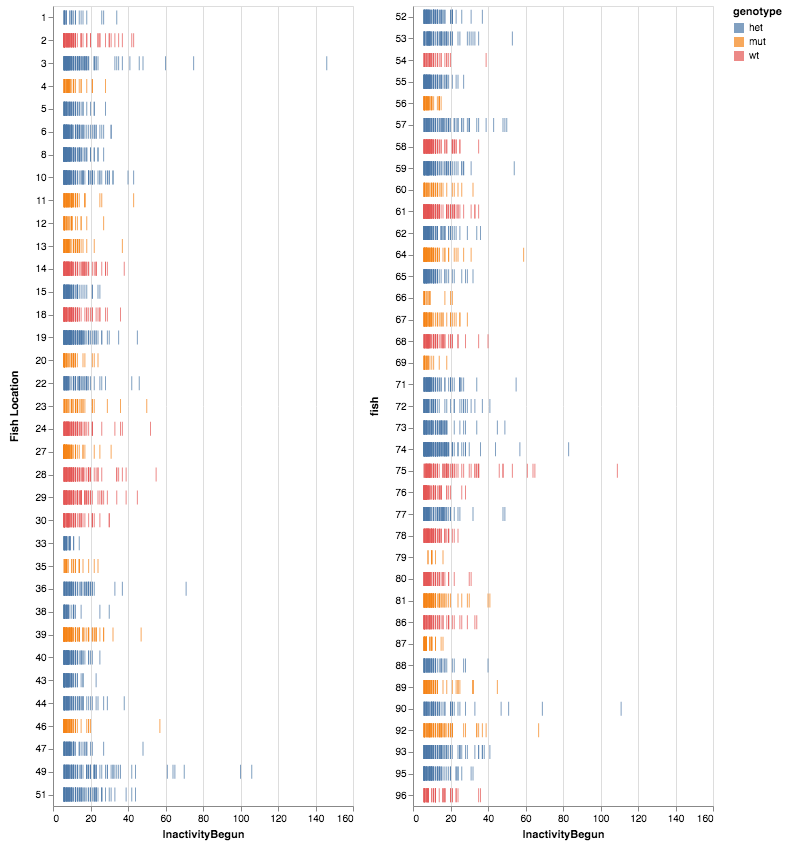

In [61]:
# Magic number 52 was chosen because it exactly splits the array of fish well locations
# into two pieces. 
p1 = alt.Chart(df_inactive[df_inactive['location'] < 52], 
               width = 300, 
               height = 800
    ).mark_tick(
    ).encode(
        x=alt.X('InactivityBegun:Q', scale=alt.Scale(domain = [THRESH, 150])),
        y=alt.Y('location:N', title='Fish Location'),
        color=alt.Color('genotype:N', title="genotype")
    )
p2 = alt.Chart(df_inactive[df_inactive['location'] >= 52], 
               width = 300,
               height = 800
    ).mark_tick(
    ).encode(
        x=alt.X('InactivityBegun:Q', scale=alt.Scale(domain = [THRESH, 150])),
        y=alt.Y('location:N', title='fish'),
        color=alt.Color('genotype:N', title="genotype")
    )
p1 | p2

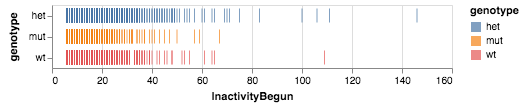

In [62]:
alt.Chart(df_inactive
    ).mark_tick(
    ).encode(
        x=alt.X('InactivityBegun:Q'),
        y=alt.Y('genotype:N', title='genotype'),
        color=alt.Color('genotype:N', title="genotype")
    )

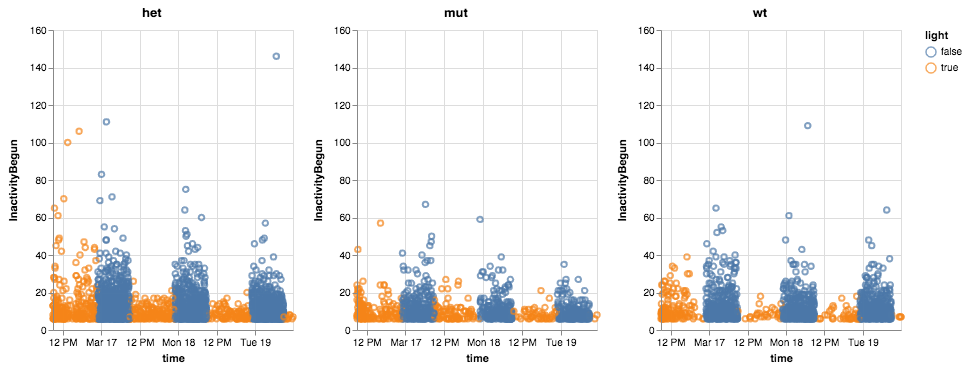

In [64]:
def get_chart(dataframe, genotype):
    return alt.Chart(dataframe[dataframe['genotype']==genotype],
                     width = 240, 
                     height = 300
                     ).mark_point(
                     ).encode(
                        x='time',
                        y=alt.Y('InactivityBegun:Q', scale=alt.Scale(domain = [THRESH, 150])),
                        color=alt.Color('light:N', title="light")
                     ).properties(title = genotype)

get_chart(df_inactive, 'het') | get_chart(df_inactive, 'mut') | get_chart(df_inactive, 'wt')

To get a better idea of the distribution of periods of inactivity across the genotypes in terms of length, let's plot an ECDF for length of periods of inactivity for each genotype.

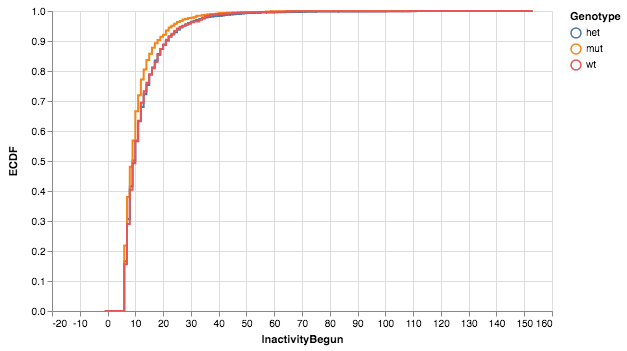

In [65]:
altcat.catplot(data=df_inactive,
               height=300,
               width = 500,
               mark='line',
               encoding=dict(x='InactivityBegun:Q',
                             color=alt.Color('genotype:N', title='Genotype')),
               transform='ecdf')

We can see from this graph that the mutant genotype has more shorter periods of inactivity (<30) than the other genotypes, suggesting that the mutant fish are more restless and thus sleep for shorter periods. We can take a closer look at this data by splitting it into the smaller values (<=30) and the larger values (>30) and comparing the behavior of the different genotypes in each.

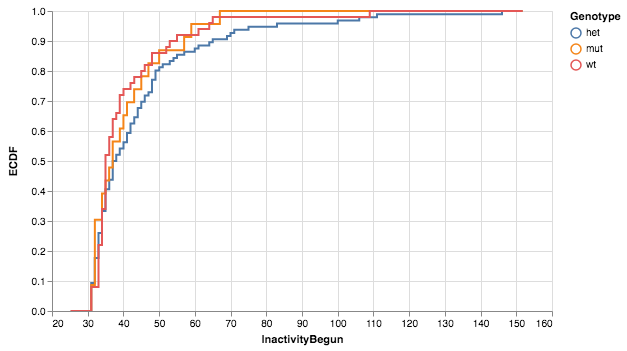

In [66]:
altcat.catplot(data=df[df["InactivityBegun"]>30],
               height=300,
               width = 500,
               mark='line',
               encoding=dict(x='InactivityBegun:Q',
                             color=alt.Color('genotype:N', title='Genotype')),
               transform='ecdf')

We can see that for the larger values, 

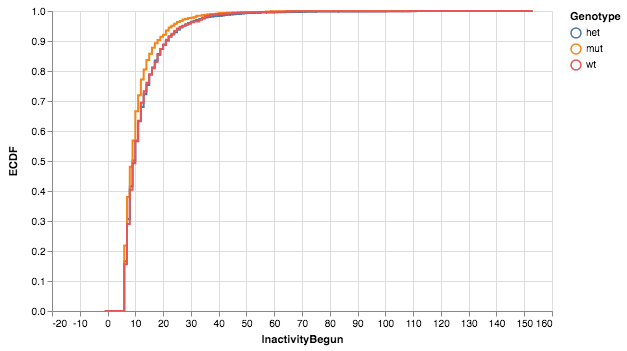

In [67]:
altcat.catplot(data=df[(df["InactivityBegun"] > 5) & (df["InactivityBegun"] < 200)],
               height=300,
               width = 500,
               mark='line',
               encoding=dict(x='InactivityBegun:Q',
                             color=alt.Color('genotype:N', title='Genotype')),
               transform='ecdf')

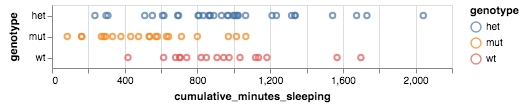

In [85]:
alt.Chart(new_df).mark_point().encode(
    alt.X('cumulative_minutes_sleeping:Q'),
    alt.Y('genotype:N'),
    color=alt.Color('genotype:N', title="genotype")
).interactive()

In [82]:
cumulative_sleeps = {}

for index, row in df_inactive.iterrows():
    location = row["location"]
    value = row["InactivityBegun"]
    if location in cumulative_sleeps.keys():
        cumulative_sleeps[location] += np.array([value, 1])
    else:
        cumulative_sleeps[location] = np.array([value, 1])
new_df = pd.DataFrame.from_dict(cumulative_sleeps, 
                                orient = 'index', 
                                columns=['cumulative_minutes_sleeping', 'wake_up_count'])
new_df['location'] = new_df.index
new_df = pd.merge(new_df, df_gt)
new_df.head()

,cumulative_minutes_sleeping,wake_up_count,location,genotype
0,297.0,25.0,1,het
1,1136.0,92.0,2,wt
2,1675.0,111.0,3,het
3,379.0,38.0,4,mut
4,552.0,53.0,5,het


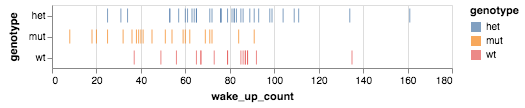

In [83]:
alt.Chart(new_df).mark_tick().encode(
    alt.X('wake_up_count:Q'),
    alt.Y('genotype:N'),
    color=alt.Color('genotype:N', title="genotype")
).interactive()

In [90]:
new_df['average_sleep_length']= new_df['cumulative_minutes_sleeping']/new_df['wake_up_count']

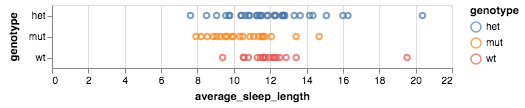

In [92]:
alt.Chart(new_df).mark_point().encode(
    alt.X('average_sleep_length:Q'),
    alt.Y('genotype:N'),
    color=alt.Color('genotype:N', title="genotype")
).interactive()